**Chapter 1** RNA-Seq Data Processing and Analysis: Alignment, Quality Control, and Quantification

**Section 1-4** Compare RSEM vs Salmon

Adapted from *STAT 115 2021 Homework 1 Problem 6*

---

We have completed RNA-Seq quantification using two different algorithms: `RSEM` and `Salmon`. In the previous section, we compared their computation speeds, where Salmon (**3** seconds) was significantly faster than RSEM (**32** seconds).

In this section, we compare the differences in quantification results between the two methods. Our analysis focuses on the following key metrics: **effective length**, **normalized read counts**, **TPM**, and **FPKM**, to evaluate the differences in their quantification outputs.

## 1 Data Preprocessing

We now focus on the following key metrics in RSEM and Salmon: **Effective Length**, **Normalized Read Count**, **TPM**, and **FPKM**.

First, we copy the RSEM result file `RSEMOut.isoforms.results` and the Salmon result file `quant.sf`, then open them using R.

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
rsemout <- read.table("RSEMOut.isoforms.results", header = 1) # Load the table
head(rsemout) # Display the first 6 rows

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,ETS1-1,700,462.14,47.0,92.85,186.60,100
2,ETS1-2_rRNA,ETS1-2,700,462.14,47.0,92.85,186.60,100
3,ETS2-1_rRNA,ETS2-1,211,7.08,0.5,64.45,129.52,100
4,ETS2-2_rRNA,ETS2-2,211,7.08,0.5,64.45,129.52,100
5,HRA1_ncRNA,HRA1,564,326.18,2.0,5.60,11.25,100
6,ICR1_ncRNA,ICR1,3199,2961.13,16.0,4.93,9.91,100


In [3]:
salmonout <- read.table("quant.sf", header = 1)
head(salmonout)

,Name,Length,EffectiveLength,TPM,NumReads
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,YDL248W_mRNA,1152,914.153,67.919553,107.958
2,YDL247W-A_mRNA,75,75.000,0.000000,0.000
3,YDL247W_mRNA,1830,1592.153,1.397396,3.869
4,YDL246C_mRNA,1074,836.153,12.380668,18.000
5,YDL245C_mRNA,1704,1466.153,0.196132,0.500
6,YDL244W_mRNA,1023,785.153,8.472899,11.567


In RSEM and Salmon, the read count metrics are `expected_count` and `NumReads`, respectively.

We analyze the *sum*, *average*, and *standard deviation* of these metrics to understand the data distribution, which helps in evaluating normalization methods.

In [4]:
rsemout %>%
  summarise(
    total_sum = sum(expected_count, na.rm = TRUE),
    average = mean(expected_count, na.rm = TRUE),
    std = sd(expected_count, na.rm = TRUE)
  )

salmonout %>%
  summarise(
    total_sum = sum(NumReads, na.rm = TRUE),
    average = mean(NumReads, na.rm = TRUE),
    std = sd(NumReads, na.rm = TRUE)
  )

total_sum,average,std
<dbl>,<dbl>,<dbl>
545041,76.47551,249.2444


total_sum,average,std
<dbl>,<dbl>,<dbl>
669927,97.89961,305.2898


The key metrics: **Effective Length**, **Normalized Read Count**, **TPM**, and **FPKM**.

Among them, `Effective Length` and `TPM` are already provided in the original datasets, but we need to process **Normalized Read Count** and **FPKM** for comparison.

**1.Normalized Read Count**

Normalized Read Count is calculated as:
$$ \text{Normalized Read Count} =\frac{\text{Read Count}}{sum\text{(Read Count)}} \times i$$
where `i` is the normalization factor. Since the total read count is in the order of Million, we use 1,000,000 as the factor. This metric is named **ReadsPerMil**.

**2.FPKM**

In RSEM, `FPKM` is already provided, but we need to compute `FPKM` for Salmon.

**FPKM (Fragments Per Kilobase of transcript per Million mapped reads)** is calculated as:
$$
FPKM=\frac{\text { expected count } \times 10^9}{\text { effective length } \times \text { total mapped reads }} = \frac{\text{Normalized Read Count}}{\text { EffectiveLength }}\times 1000
$$
Since we already normalized read counts with a factor of 1,000,000 , we multiply by 1000 to match the factor in the FPKM formula.

Data Processing:

In [5]:
# Data Processing
Salmon <- salmonout %>%
  mutate(
    ReadsPerMil_Salmon = NumReads/(sum(NumReads)/1000000), # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
    FPKM_Salmon = ReadsPerMil_Salmon / EffectiveLength * 1000, # 计算FPKM
    TPM_Salmon = TPM,
    EffectiveLength_Salmon = EffectiveLength
  ) %>%
  select(
    -Length, -NumReads,
    -EffectiveLength, -TPM
  )
head(Salmon)

RSEM <- rsemout %>%
  mutate(
    ReadsPerMil_RSEM = expected_count/(sum(expected_count)/1000000), # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
    FPKM_RSEM = FPKM,
    TPM_RSEM = TPM,
    EffectiveLength_RSEM = effective_length
  ) %>%
  select(
    -gene_id, -length, -effective_length,
    -expected_count, -IsoPct, -TPM, -FPKM
  )
head(RSEM)

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,YDL248W_mRNA,161.148900,176.2821979,67.919553,914.153
2,YDL247W-A_mRNA,0.000000,0.0000000,0.000000,75.000
3,YDL247W_mRNA,5.775256,3.6273248,1.397396,1592.153
4,YDL246C_mRNA,26.868599,32.1335915,12.380668,836.153
5,YDL245C_mRNA,0.746350,0.5090533,0.196132,1466.153
6,YDL244W_mRNA,17.266060,21.9906951,8.472899,785.153


,transcript_id,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,86.2320513,186.60,92.85,462.14
2,ETS1-2_rRNA,86.2320513,186.60,92.85,462.14
3,ETS2-1_rRNA,0.9173622,129.52,64.45,7.08
4,ETS2-2_rRNA,0.9173622,129.52,64.45,7.08
5,HRA1_ncRNA,3.6694490,11.25,5.60,326.18
6,ICR1_ncRNA,29.3555919,9.91,4.93,2961.13


Distribution of `ReadsPerMil` and `FPKM`

In [6]:
Salmon %>%
  summarise(
    ReadsPerMil_Salmon_total_sum = sum(ReadsPerMil_Salmon, na.rm = TRUE),
    ReadsPerMil_Salmon_average = mean(ReadsPerMil_Salmon, na.rm = TRUE),
    ReadsPerMil_Salmon_std = sd(ReadsPerMil_Salmon, na.rm = TRUE),
    FPKM_Salmon_total_sum = sum(FPKM_Salmon, na.rm = TRUE),
    FPKM_Salmon_average = mean(FPKM_Salmon, na.rm = TRUE),
    FPKM_Salmon_std = sd(FPKM_Salmon, na.rm = TRUE)
  )

RSEM %>%
  summarise(
    ReadsPerMil_RSEM_total_sum = sum(ReadsPerMil_RSEM, na.rm = TRUE),
    ReadsPerMil_RSEM_average = mean(ReadsPerMil_RSEM, na.rm = TRUE),
    ReadsPerMil_RSEM_std = sd(ReadsPerMil_RSEM, na.rm = TRUE),
    FPKM_RSEM_total_sum = sum(FPKM_RSEM, na.rm = TRUE),
    FPKM_RSEM_average = mean(FPKM_RSEM, na.rm = TRUE),
    FPKM_RSEM_std = sd(FPKM_RSEM, na.rm = TRUE)
  )

ReadsPerMil_Salmon_total_sum,ReadsPerMil_Salmon_average,ReadsPerMil_Salmon_std,FPKM_Salmon_total_sum,FPKM_Salmon_average,FPKM_Salmon_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1e+06,146.1347,455.706,2595456,379.2863,1854.047


ReadsPerMil_RSEM_total_sum,ReadsPerMil_RSEM_average,ReadsPerMil_RSEM_std,FPKM_RSEM_total_sum,FPKM_RSEM_average,FPKM_RSEM_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1e+06,140.3115,457.2947,2009736,281.989,1182.745


Merge Salmon and RSEM data using the *transcript ID* (`Name` in Salmon and `transcript_id` in RSEM).

In [7]:
dat <- Salmon %>%
  merge(
    RSEM, by.x = "Name", by.y = "transcript_id"
  )
head(dat)

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,191.0656,413.36147,159.262780,462.224,86.2320513,186.60,92.85,462.14
2,ETS2-1_rRNA,0.0000,0.00000,0.000000,23.544,0.9173622,129.52,64.45,7.08
3,HRA1_ncRNA,0.0000,0.00000,0.000000,326.399,3.6694490,11.25,5.60,326.18
4,ICR1_ncRNA,17.9124,6.04913,2.330653,2961.153,29.3555919,9.91,4.93,2961.13
5,IRT1_ncRNA,82.0985,65.61827,25.281891,1251.153,97.2403982,77.72,38.67,1251.13
6,ITS1-1_rRNA,5.9708,47.46528,18.287793,125.793,6.4215357,51.87,25.81,123.81


## 2 Compute Pearson Correlation Matrix

By computing the Pearson correlation matrix, we can observe the linear correlation between the metrics obtained from the Salmon and RSEM methods.

In [8]:
library(reshape2)

get_upper_tri <- function(cormat) {
  cormat[lower.tri(cormat)] <- NA
  return(cormat)
}

cormat <- dat %>%
  select(-Name) %>%
  cor() %>% # Compute Pearson correlation coefficients between variables, outputting a correlation matrix.
  get_upper_tri() %>% # Retain the upper triangular part of the correlation matrix, hiding redundant symmetric information.
  melt(na.rm = TRUE) # Convert the matrix into a long-format dataframe (one-dimensional table) for heatmap visualization.

head(cormat)


,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,ReadsPerMil_Salmon,ReadsPerMil_Salmon,1.0000000
9,ReadsPerMil_Salmon,FPKM_Salmon,0.3911869
10,FPKM_Salmon,FPKM_Salmon,1.0000000
17,ReadsPerMil_Salmon,TPM_Salmon,0.3911827
18,FPKM_Salmon,TPM_Salmon,1.0000000
19,TPM_Salmon,TPM_Salmon,1.0000000


Plot **Heatmap**

Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."


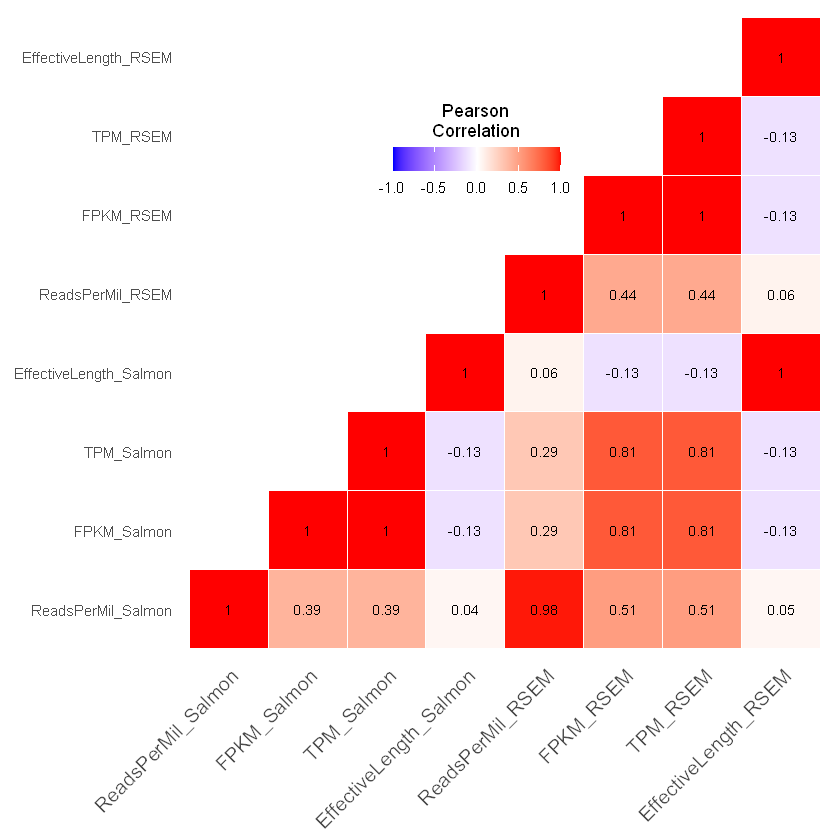

In [9]:
# Plot heatmap

ggheatmap <- ggplot(cormat, aes(Var2, Var1, fill=value)) +
  geom_tile(color = "white") +  # Draw heatmap cells
  scale_fill_gradient2(
    low = "blue", high = "red", mid = "white",
    midpoint = 0, limit = c(-1, 1), space = "Lab",
    name = "Pearson\nCorrelation"
  ) +  # Define color gradient (from negative correlation in blue to positive correlation in red)
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1,
                                   size = 12, hjust = 1)) +
  coord_fixed() +
  geom_text(
    aes(Var2, Var1, label = round(value, 2)),
    color = "black",
    size = 3
  ) +  # Add correlation coefficient labels within the heatmap.
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    legend.justification = c(1, 0),
    legend.position = c(0.6, 0.7),
    legend.direction = "horizontal"
  ) +
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                               title.position = "top", title.hjust = 0.5))

print(ggheatmap)


**Observations from the Heatmap:**

1. `Effective Length` from RSEM and Salmon are perfectly correlated.
2. However, `Effective Length` has almost no correlation with the other three metrics from both methods.
3. `ReadsPerMil` (normalized read count) from RSEM and Salmon are nearly perfectly correlated.
4. `ReadsPerMil` has low correlation with TPM and FPKM from both methods.
5. TPM and FPKM from RSEM and Salmon are highly correlated (Pearson correlation coefficient = 0.81).

**Additional Observations:**

1. `FPKM` and `TPM` within RSEM are perfectly correlated.
2. `FPKM` and `TPM` within Salmon are also perfectly correlated.

Moreover, almost all correlation coefficients are positive.

## 3 Scatter Plots Between Different Metrics

We generate scatter plots for different metrics to observe the correlation and quantitative differences between them.

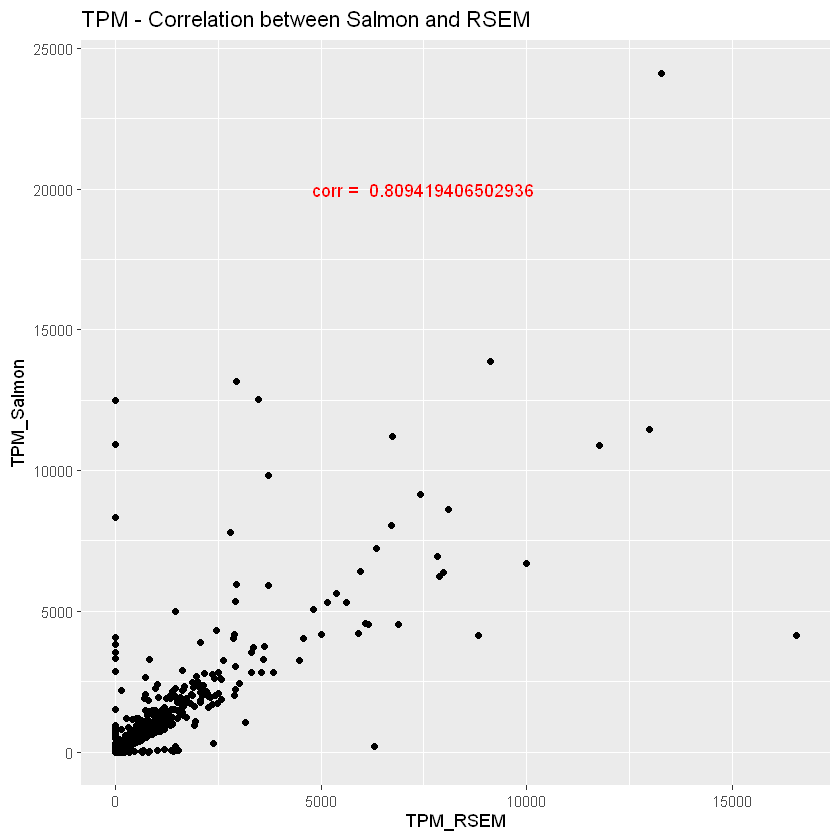

In [10]:
corr1 <- cormat[which(cormat$Var2 == "TPM_RSEM" & cormat$Var1 == "TPM_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = TPM_RSEM, y = TPM_Salmon)) + 
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr1), color = "red")+
  ggtitle("TPM - Correlation between Salmon and RSEM")

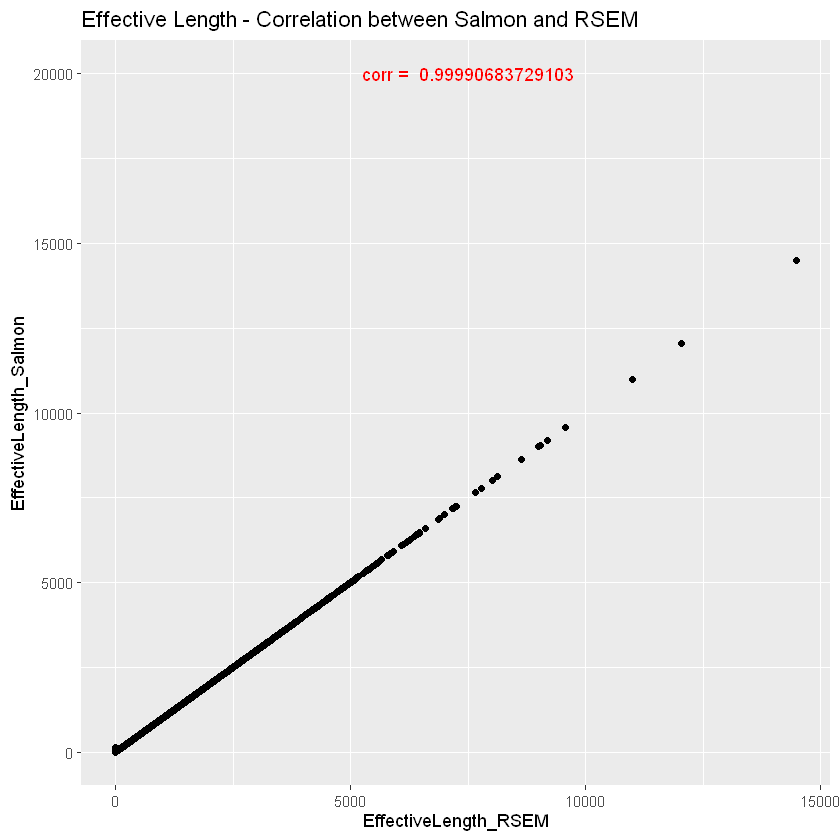

In [11]:
corr2 <- cormat[which(cormat$Var2 == "EffectiveLength_RSEM" &
                        cormat$Var1 == "EffectiveLength_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = EffectiveLength_RSEM, y = EffectiveLength_Salmon)) +
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr2), color = "red") +
  ggtitle("Effective Length - Correlation between Salmon and RSEM")

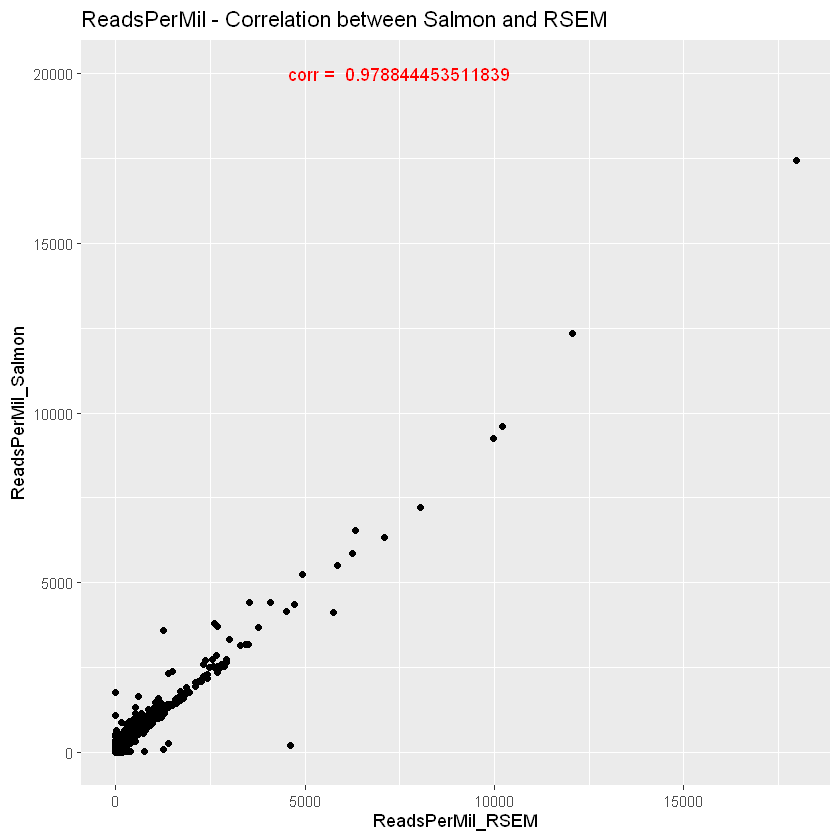

In [12]:
corr3 <- cormat[which(cormat$Var2 == "ReadsPerMil_RSEM" &
                        cormat$Var1 == "ReadsPerMil_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = ReadsPerMil_RSEM, y = ReadsPerMil_Salmon)) +
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr3), color = "red") +
  ggtitle("ReadsPerMil - Correlation between Salmon and RSEM")